# Hyperion Capstone 7

This project will focus on comparing the [K-mean](https://en.wikipedia.org/wiki/K-means_clustering) and the [KNN](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) methods of clustering data after applying Principle Componant Analysis. The dataset used in this notebook will be [US arrest statistics](https://www.kaggle.com/datasets/kurohana/usarrets). This dataset is described as; Arrests per 100,000 residents for assult, murder, and rape in each of the 50 US states in 1973.

The project strucutre:
- A small EDA on the dataset
- Applying PCA and tuning the number of principle componants
- Training a K-mean model
- Training a KNN model
- Comparing both models

In [29]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

## Loading and exploring data

In this section I will be looking at the data set and looking at the different attributes and how they link together. I will also be dealing with any empty values.

In [30]:
#Load data
df = pd.read_csv("UsArrests.csv")

#Checking for empty cells
df.info()

#Gets the first 5 rows
print("\n\nTop of the dataset:\n",df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


Top of the dataset:
          City  Murder  Assault  UrbanPop  Rape
0     Alabama    13.2      236        58  21.2
1      Alaska    10.0      263        48  44.5
2     Arizona     8.1      294        80  31.0
3    Arkansas     8.8      190        50  19.5
4  California     9.0      276        91  40.6


This initial opening of the dataset tells us that there are no empty cells that need to be dealt with. It also seems that the attribute names "City" is named wrong and should be "State" instead. The next step will be analysing the distribution of each statistic throughout the dataset.

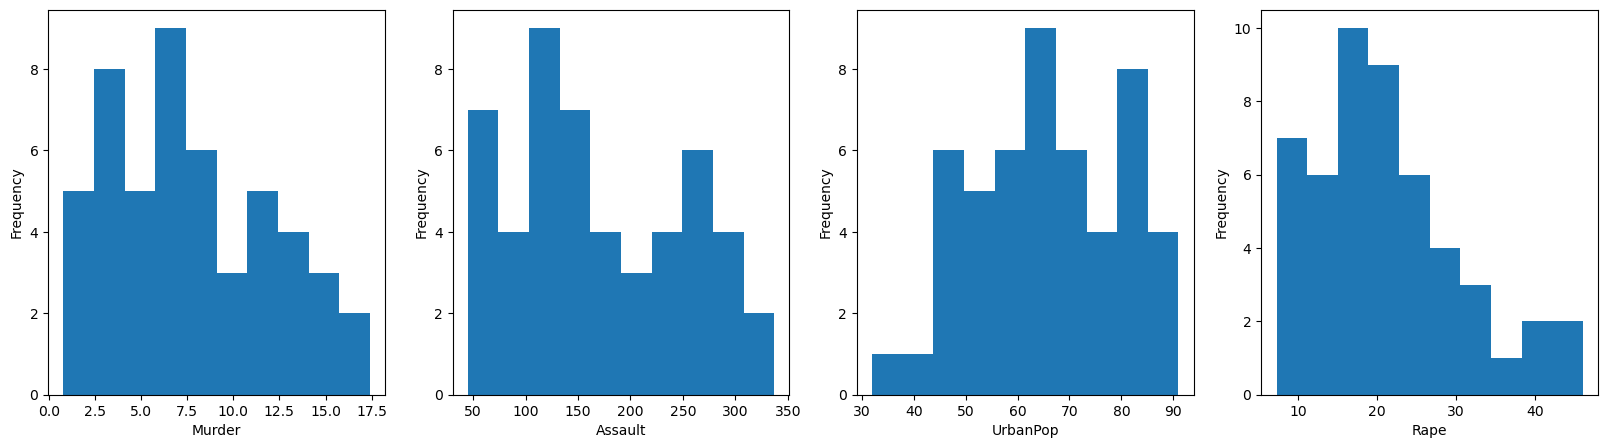

In [31]:
#Changes name of the "City" column
df.rename(columns={"City":"State"},inplace=True)

#Selects subset only containing numeric data
df_num = df.drop("State",axis=1)
df_states = df.State

#Generates subplots
fig,axs = plt.subplots(1,4,figsize=(20,5))

#Plots a histogram of each numeric column
for col,ax in zip(df_num,fig.axes):
    df[col].plot.hist(ax=ax)
    ax.set_xlabel(col)

**Murder per Capita**
- The most common rate of murder is around 2.5 and 7.5.
- Rates above 11 are must rarer.

**Assult per Capita**
- The rates have a similar shape to the murder rates, but the absolute values are much higher.
- Peak at 125, though there is another peak at 275.

**Urban Population**
- Most states have an urban population of around 65%.
- There seems to be a much more even spread of populations between 45% and 95% compared to the other statistic types.

**Rape per Capita**
- More rape occures in general than murders
- More assults then rapes
- There a rapid dropoff for rates above 25